# Projekt PRIAD

## Rozpoznawanie autora utworu literackiego na podstawie treści utworu z wykorzystaniem worka słów.

### Stanisław Maliński, Jan Stachurski

___

Importy

In [58]:
import os
import pandas as pd
import numpy as np
from math import log

pd.options.display.float_format = "{:.8f}".format 

In [59]:
import warnings
warnings.filterwarnings("ignore")

Wczytywanie danych

In [60]:
data_path = "./data/"
file_list = os.listdir(data_path)
func = lambda  a : a.replace(".txt", "").split("-")
count_size = lambda a : os.stat(a).st_size
data = [[func(title)[0], func(title)[1], data_path + title, count_size(data_path + title)] for title in file_list]
files = pd.DataFrame(data, columns=['Author', 'Name of The work', 'FilePath', 'FileSize'])

Przedstawiam zestaw uczący. Mamy tutaj pozycję kilku Polskich autorów.

In [61]:
tmp = files.drop(columns=['Name of The work', 'FilePath', 'FileSize'])
tmp = pd.concat([tmp, pd.Series(np.where(tmp['Author']!=None,1,1))], axis=1).groupby('Author').sum()
tmp.columns = ['Book Count']
print(tmp.groupby('Author').sum())

                   Book Count
Author                       
AdamMickiewicz              7
HenrykSienkiewicz          11
Juliusz Słowacki            8


In [62]:
files

,Author,Name of The work,FilePath,FileSize
0,AdamMickiewicz,DziadyII,./data/AdamMickiewicz-DziadyII.txt,24897
1,AdamMickiewicz,DziadyIII,./data/AdamMickiewicz-DziadyIII.txt,152297
2,AdamMickiewicz,DziadyIV,./data/AdamMickiewicz-DziadyIV.txt,65206
3,AdamMickiewicz,Grażyna,./data/AdamMickiewicz-Grażyna.txt,50418
4,AdamMickiewicz,KonradWallendrod,./data/AdamMickiewicz-KonradWallendrod.txt,89271
5,AdamMickiewicz,PanTadeusz,./data/AdamMickiewicz-PanTadeusz.txt,492037
6,AdamMickiewicz,Żywila,./data/AdamMickiewicz-Żywila.txt,12387
7,HenrykSienkiewicz,Bez dogmatu,./data/HenrykSienkiewicz-Bez dogmatu.txt,894478
8,HenrykSienkiewicz,Co się raz stało w Sydonie,./data/HenrykSienkiewicz-Co się raz stało w Sy...,26358
9,HenrykSienkiewicz,Krzyżacy Tom I,./data/HenrykSienkiewicz-Krzyżacy Tom I.txt,738692


Wczytanie stop-słów:

In [5]:
delimeters = ["\\n", "'"]
stop_word = set()
with open("./stopyPL.txt", encoding="utf8") as f:
    for line in f:
        word = repr(line)
        for c in delimeters:
            word = word.replace(c, "")
        stop_word.add(word)

Projekt ten używa worka słów, który to przechowuje informacje na temat częstości występowania słów w danym dokumencie. Celem tego projektu jest sprawdzenie jak dobry klasyfikator autora dla danego dzieła można wykonać, przy pomocy właśnie tego podejścia. Następująca część notbook'a służy do tworzenia funkcji pomocniczych, które ułatwią nam to zadanie.

___

Funckje do standaryzacji słów tzn. usunięcia ewentualnych znaków graficznych takich jak kropka czy przecinek oraz ustawienie wielkości liter na małe aby słowa "Który?" oraz "który" były zliczane jako to same słowo.

In [6]:
special_chars = ".,-?()!\\\":;*…0123456789"
def normalize_text(word):
    for char in special_chars:
        word = word.replace(char, "")
    word = word.lower()
    return word

Funkcja do wczytywania tekstu z plików oraz wczytywanie go do pamięci podręcznej

In [7]:
def get_text(FileName):
    out = ""
    n = 0
    with open(FileName, "r", encoding="utf8") as f:
        for line in f:
            out += line
            n += 1
        f.close()
    return out

Funkcja, która służy do tworzenia worków słów, działającach w 3 trybach:
* 0 - Tworzenie worka słów ze wszystkich słów.   
* 1 - Tworzenie worka słów bez stop słów.   
* 2 - Tworzenie wokra słów na stop słowach.   

Wprowadziliśmy tu pojęcie stop słów, pod pojęciem tym kryją się słowa, które nie dostarczają nam informacji na temat samej akcji, a raczej strukturyzują zdanie, są to słowa takie jak 'i' lub 'lub'.

In [8]:
# 0 - generete bag with all words, 1 - bag without stopwords, 2 - bag with only stopwords
def generate_word_bag(text, mode=0, nwords=None):
    word_bag = {}
    words_in_bag = 0
    if isinstance(text, str):
        text = text.split("\n")
    for line in text:
        word = word.split()
        if nwords is not None and words_in_bag >= nwords:
            break
        if word == '':
            continue
        if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
            words_in_bag += 1
            if word in word_bag:
                word_bag[word] += 1
            else:
                word_bag[word] = 1
    return word_bag

Mamy już mały warsztat narzędzi do tworzenia wektorów cech dla utworów. Stworzymy teraz parę funckji, które pozwolą nam zgrabnie manipulować macierzą danych. 
merge_dics_to_df - łączy worki słów w ramkę danych, którą później wykorzystamy do nauki klasyfikatora.

In [10]:
def merge_dics_to_df(dics, labels=None):
    tab = []
    word_found = set()
    index = []
    for dic in dics:
        words = list(dic.keys())
        for word in words:
            if not word in word_found:
                word_found.add(word)
                index.append(word)
                rec = []
                for dictionary in dics:
                    if word in dictionary:
                        rec.append(dictionary[word])
                        del dictionary[word]
                    else:
                        rec.append(0)
                tab.append(rec)
   
    df = pd.DataFrame(tab, columns=labels, index=index)   
    return df.T

No i oczywiście funkcja do tworzenia macierzy danych ze wszystkich dostarczonych dzieł.

In [11]:
def load(files, mode=2):
    word_bags = []
    index = []
    labels = []

    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        cont = get_text(path)
        cont = normalize_text(cont)
        word_bags.append(generate_word_bag(cont, mode=mode))
        index.append(name)
        labels.append(label)
        
    df = merge_dics_to_df(word_bags)
    df['labels'] = labels
    df['Name'] = index
    df = df.set_index('Name')
    return df   

Funkcja obliczająca częstotliwość wystąpienia danego słowa w worku słów.   (Nie bierzemy tu pod uwagę częstości występowania w całym dziele a jedynie w worku słów)

In [12]:
def frequency(data):
    df = data.copy()
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    fdf = pd.DataFrame(tf, columns=df.columns)
    if w_l:
        fdf['labels'] =  pd.Series.tolist(labels)
    return fdf

Funkcja do usuwania słów z worka jeżeli nie wstępuje ono dostatecznie dużo razy.

In [13]:
def drop_threshold(df, threshold):
    to_drop = []
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    for col in df.columns:
        if (df[col] < threshold).all():
            to_drop.append(col)
    df = df.drop(columns=to_drop)
    if w_l:
        df['labels'] = pd.Series.tolist(labels)
    return df

tfidf - Jest to metryka częstości, którą oblicza się w taki sposób:
    
    tfij = nij/sum(nkj)\[po j\]
    
nij -  jest liczbą wystąpień termu ti w dokumencie dj
    
    idfi = log(|D|/|{d: istnieje conajmniej jedno wystąpienie ti w d}|)
    
D - jest liczbą dzieł w macierzy danych
    
    tfidf(i,j) = tfij * idfi

In [14]:
def tfidf(data):
    df = data.copy()
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    inbooks = np.array((df > 0)*1).sum(axis=0)
    idf = [log(nbooks / val, 10) for val in inbooks]
    tfidf = pd.DataFrame((tf*np.array([idf,]*nbooks)*100), columns=df.columns)
    if w_l:
        tfidf['labels'] = pd.Series.tolist(labels)
    tfidf.replace([np.nan, np.inf, -np.inf], 0, inplace=True)
    return tfidf

Połączenie wszystkich dzieł jednego autora w jeden wiersz w tabeli. W celu stworzenia pewnego prototypu autora od którego będziemy liczyć odległość w przestrzeni utworów.

In [15]:
def merge_author(df):
    d = pd.concat([df['opis_ucz'], df['dec_ucz']], axis=1)
    d.groupby('labels').sum()
    df['dec_ucz'] = d.loc[:,'labels']
    df['opis_ucz'] = d.drop(columns=['labels'])
    return df

Jak widzimy mamy już ramkę danych, w której każdym obiektem jest dzieło a wektorem atrybutów jest częstość wystąpień poszczególnych słów w każdym z dzieł. Dodaliśmy również atrybuty decyzyjny czyli nazwisko autora danego dzieła.

___

Przeprowadzimy teraz krótką analizę zbioru uczącego.

In [16]:
data1 = load(files, mode=1)
data1 = drop_threshold(data1, 50)
data2 = load(files, mode=2)
data2 = drop_threshold(data2, 50)
data3 = pd.concat([data1.drop(columns=['labels']), data2], axis=1)
data3 = drop_threshold(data3, 50)

In [17]:
grouped = data1.groupby('labels')
grouped.sum()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,79,78,15,43,10,58,29,65,32,978,...,0,0,0,0,0,0,0,0,0,0
HenrykSienkiewicz,350,591,117,200,410,689,697,814,297,0,...,87,51,88,1,0,0,0,0,0,0
Juliusz Słowacki,27,35,16,34,13,48,14,46,51,784,...,0,0,0,81,53,52,176,83,99,60


Widzmy z pierwszej figury, że autor Słowacki używa jako jedyny słów takich jak "Kalego" czy "Anheli", na pierwszy rzut oka jest to dla nas dobra informacja, ponieważ znaleźliśmy słowo specyficzne dla jednego autora!

In [20]:
data1[data1['labels'] == "Juliusz Słowacki"]

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick,labels
Name,,,,,,,,,,,,,,,,,,,,,
Anhelli,0,3,3,0,0,8,2,3,0,0,...,0,0,0,52,52,0,0,0,0,Juliusz Słowacki
Balladyna,6,3,0,0,0,3,2,4,2,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Beniowski dalsze pieśni,7,13,8,12,2,10,5,10,6,0,...,0,0,51,0,0,0,0,0,0,Juliusz Słowacki
Beniowski pięć pierwszych pieśni,0,4,1,3,11,5,1,11,10,0,...,0,0,30,1,0,0,0,0,0,Juliusz Słowacki
Hugo,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Kordian,4,7,2,9,0,12,4,6,10,444,...,0,0,0,0,0,176,0,0,0,Juliusz Słowacki
Król Duch,0,2,1,6,0,5,0,1,4,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Maria Stuart,10,3,1,4,0,3,0,11,18,340,...,0,0,0,0,0,0,83,99,60,Juliusz Słowacki


Niestety już tu widzimy, że słowo charakterystyczne dla danego autora jest również charakterystyczne dla jego jednej książki. Co oznacza, że słowa te nie występują w innych jego dziełach. Fakt ten sprawia, że słowo to staje się nie tylko zbędne podczas klasyfikacji a i może utrudnić proces uczenia. A więc poszukujemy słów, które występuje stosunkowo często u pewnego autora i występuje ono w każdym z jego dzieł. A więc poszukujemy słów o wysokiej częstości oraz małej wariancji częstości dla danego autora.

In [21]:
data11 = frequency(data1).groupby('labels')
data11.mean()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.00724361,0.00458395,0.00115931,0.00467281,0.00079948,0.00591032,0.00339803,0.00726039,0.00311979,0.08352076,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
HenrykSienkiewicz,0.00134837,0.00299250,0.00052203,0.00095857,0.00175504,0.00311445,0.00307992,0.00400042,0.00207239,0.00000000,...,0.00052531,0.00030794,0.00053135,0.00000604,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Juliusz Słowacki,0.00218229,0.00252706,0.00108285,0.00233043,0.00064361,0.00563872,0.00107270,0.00319985,0.00422503,0.04010351,...,0.00000000,0.00000000,0.00000000,0.00355809,0.00679405,0.00674274,0.00807932,0.00481439,0.00574246,0.00348028


In [22]:
data11.var()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.00003525,0.00000887,0.00000236,0.00003532,0.00000261,0.00002431,0.00001757,0.00003732,0.00000741,0.01383430,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
HenrykSienkiewicz,0.00000124,0.00000108,0.00000119,0.00000030,0.00000057,0.00000130,0.00000051,0.00000153,0.00000695,0.00000000,...,0.00000304,0.00000104,0.00000311,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Juliusz Słowacki,0.00001056,0.00000222,0.00000138,0.00000833,0.00000250,0.00001739,0.00000131,0.00000402,0.00000746,0.00551614,...,0.00000000,0.00000000,0.00000000,0.00004446,0.00036295,0.00036372,0.00052220,0.00018543,0.00026381,0.00009690


W celu usunięcia słów, które pojawiają się wyłącznie w pojedyńczych dziełach możemy przyjąć pewne założenie, iż klasyfikacje będziemy przeprowadzać jedynie na stop słowach. Słowa te nie będą charakterystyczne dla pojedyńczego autora czy dzieła, ponieważ pojawiają sie one w języku każdego człowieka, za to częstość ich występowania, może (i najprawdopodobnie jest) uzależniona od przyzwyczajenia do pewnej maniery w jakiej pewna osoba mówi. Dodatkową korzyścią takiego rozwiązania jest zdecydowanie oszczędności obliczeniowe.

In [23]:
data22 = frequency(data2).groupby('labels')
data22.mean()

,jest,to,między,w,i,na,ta,się,której,ponieważ,...,dlatego,jednak,jakkolwiek,bardziej,również,bowiem,znów,gdyż,natomiast,jednakże
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.00759796,0.02118174,0.00211013,0.06585508,0.09040866,0.05143150,0.00214925,0.05228538,0.00095152,0.00011521,...,0.00042934,0.00038371,0.00016881,0.00021164,0.00007055,0.00006136,0.00009789,0.00049897,0.00000000,0.00000000
HenrykSienkiewicz,0.00846081,0.02783110,0.00226234,0.05169300,0.09089083,0.04416244,0.00132771,0.06156951,0.00167132,0.00064421,...,0.00143016,0.00339011,0.00033040,0.00091450,0.00067037,0.00125311,0.00213259,0.00213619,0.00070746,0.00066378
Juliusz Słowacki,0.00931093,0.01960182,0.00174021,0.07143824,0.08994592,0.05656008,0.00330432,0.05377965,0.00101126,0.00004891,...,0.00045795,0.00082959,0.00010739,0.00054774,0.00000000,0.00068175,0.00169873,0.00000000,0.00000000,0.00000000


In [24]:
data22.var()

,jest,to,między,w,i,na,ta,się,której,ponieważ,...,dlatego,jednak,jakkolwiek,bardziej,również,bowiem,znów,gdyż,natomiast,jednakże
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.00000241,0.00006231,0.00000168,0.00015466,0.00029625,0.00015100,0.00000337,0.00009752,0.00000078,0.00000009,...,0.00000037,0.00000048,0.00000011,0.00000010,0.00000002,0.00000003,0.00000007,0.00000165,0.00000000,0.00000000
HenrykSienkiewicz,0.00002837,0.00002365,0.00000023,0.00001082,0.00010484,0.00002163,0.00000041,0.00001748,0.00000027,0.00000071,...,0.00000031,0.00000428,0.00000005,0.00000004,0.00000006,0.00000012,0.00000060,0.00000250,0.00000010,0.00000024
Juliusz Słowacki,0.00002720,0.00002857,0.00000134,0.00023212,0.00083472,0.00007695,0.00000112,0.00008299,0.00000150,0.00000001,...,0.00000019,0.00000058,0.00000009,0.00000034,0.00000000,0.00000071,0.00000307,0.00000000,0.00000000,0.00000000


Już na tym poziomie widzmy pewne prawidłowości. Jak widać Sienkiewicz jako jedyny używa słowa 'jednakże' oraz 'natomiast', a mała wariancja dla tych słów implikuje, że autor ten używa tego słowa dość regularnie w swoich dziełach. Tą teze bardzo łatwo zweryfikować.

In [57]:
data2['jednakże']

Name
DziadyII                             0
DziadyIII                            0
DziadyIV                             0
Grażyna                              0
KonradWallendrod                     0
PanTadeusz                           0
Żywila                               0
Bez dogmatu                         16
Co się raz stało w Sydonie           0
Krzyżacy Tom I                      52
Krzyżacy Tom II                     65
OgniemIMieczemTom1                  19
Pan Wołodyjowski                    37
Potop Tom I                         20
Potop Tom II                        36
Potop Tom III                       13
Quo vadis                           50
W pustyni i w puszczy               66
Anhelli                              0
Balladyna                            0
Beniowski dalsze pieśni              0
Beniowski pięć pierwszych pieśni     0
Hugo                                 0
Kordian                              0
Król Duch                            0
Maria Stuart        

Obserwacja ta prowadzi nas do kolejnego etapu analizy jaką jest uczenie klasyfikatora.

___

Teraz musimy stworzyć model, który będzie klasyfikował do jakiego autora należy dany utwór.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

import matplotlib.pyplot as plt
import random
import re

Metoda get_learning_data dzieli naszą macierz danych na dane uczące oraz testowe w pewnej proporcji. Dzięki temu będziemy mogli zweryfikować jak dobry nasz model jest.

In [27]:
def get_learning_data(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.drop(columns='labels'), df['labels'].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

Dodatkowo użyjemy metody, która służy do weryfikacji jak dobrymi danymi uczącymi są dostarczone dane.

In [28]:
def weryfikuj(model, data, show=True):
    model.fit(data['opis_ucz'], data['dec_ucz'])
    
    learn_s = model.score(data['opis_ucz'], data['dec_ucz'])
    test_s  = model.score(data['opis_test'], data['dec_test'])
    
    if show:
        print("\tWynik dla danych uczących: ", end="")
        print(learn_s)
        print("\tWynik dla danych testowych: ", end="")
        print(test_s)
    
    return learn_s, test_s

In [37]:
models = (("NS", KNeighborsClassifier(n_neighbors=1)), 
          ("KNS5", KNeighborsClassifier(n_neighbors=5)),
          ("KNS10", KNeighborsClassifier(n_neighbors=10)), 
          ("BK", GaussianNB()),
          ("DT5", tree.DecisionTreeClassifier(max_depth=5)),
          ("DT10", tree.DecisionTreeClassifier(max_depth=10)))
liczba_prób = 1000

Przeprowadzimy teraz klasyfikacje na danych testowych w dziewięciu wariantach:
* Worek słów składa się wyłącznie z stop słów.   
* Worek słów składa się ze słów, które nie są stop słowami.   
* Worek słów będzie składał się ze wszystkich słów.  
* Worek słów składa się wyłącznie z stop słów z metryką tfidf.  
* Worek słów składa się ze słów, które nie są stop słowami z metryką tfidf. 
* Worek słów będzie składał się ze wszystkich słów z metryką tfidf.  
* Worek słów będzie sumą wszystkich słów używanych przez autora we wszystkich dziełach.   
* Worek słów będzie sumą wszystkich stop słów używanych przez autora we wszystkich dziełach. 
* Worek słów będzie sumą wszystkich wszystkich słów używanych przez autora we wszystkich dziełach. 

Do wykonania tego zadania posłużą nam metoday:

In [32]:
def test_classifiers(df_o, tfidf_arg=False, NS=False, tries=100):
    res = {}
    df = df_o.copy()
    progress = len(models)*tries
    if not tfidf_arg:
        df = frequency(df)
    for index, name_mod in enumerate(models):
        name, mod = name_mod
        if NS and name != 'NS': continue
        if mod is None:
            break
        sum_t = 0
        sum_l = 0
        line = "Ukończono w {pr:.2f}%"
        for i in range(tries):
            data = get_learning_data(df, 0.3)
            if tfidf_arg:
                data['opis_ucz'] = tfidf(data['opis_ucz'])
                data['opis_test'] = tfidf(data['opis_test'])
            d_l, d_t= weryfikuj(mod, data, show=False)
            sum_l += d_l
            sum_t += d_t
            if NS:
                print(line.format(pr=(index*tries + i + 1)*100/tries,) , end='\r')
            else:
                print(line.format(pr=(index*tries + i + 1)*100/progress,) , end='\r')
        res[name] = (sum_l/tries, sum_t/tries)
    respd = pd.DataFrame(res, index=["uczące", "testowe"])
    
    return respd.T.sort_values(by='testowe')

Najpierw wykonamy klasyfikacje wyłącznie używając częstości wystąpień danych słów w danym dziele:

Klasyfickaja bez stop słów


<AxesSubplot:>

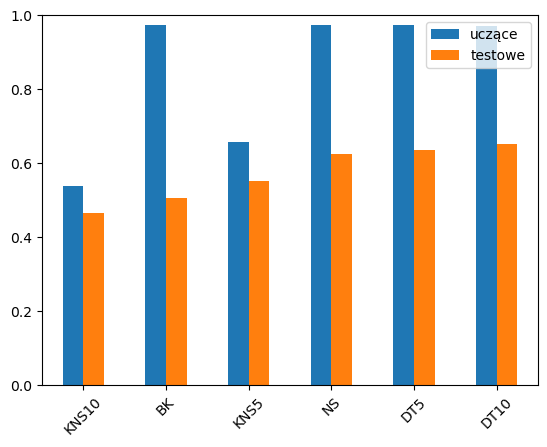

In [49]:
print("Klasyfickaja bez stop słów")
respd1 = test_classifiers(data1, tries=liczba_prób)
respd1.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na stop słowach


<AxesSubplot:>

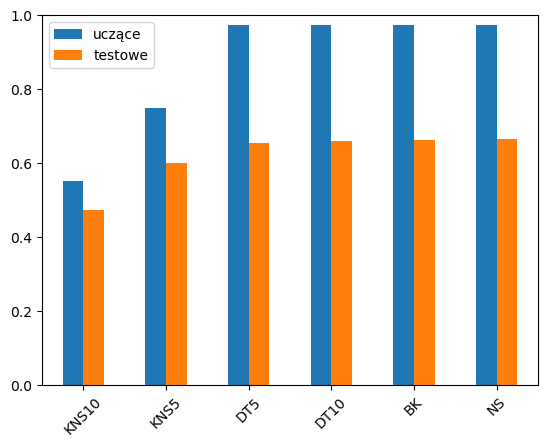

In [39]:
print("Klasyfickaja na stop słowach")
respd2 = test_classifiers(data2, tries=liczba_prób)
respd2.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na wszystkich słowach


<AxesSubplot:>

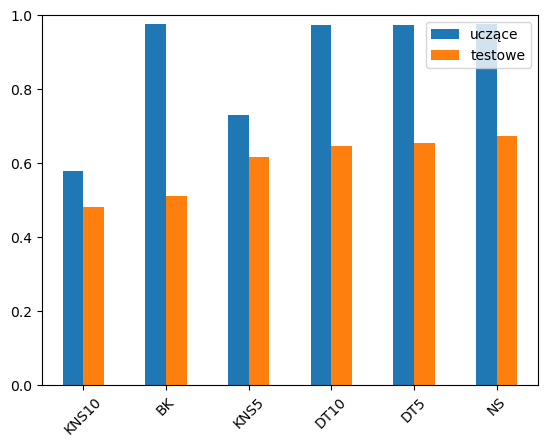

In [40]:
print("Klasyfickaja na wszystkich słowach")
respd3 = test_classifiers(data3, tries=liczba_prób)
respd3.plot(kind='bar', rot = 45,  ylim=[0,1])

<AxesSubplot:>

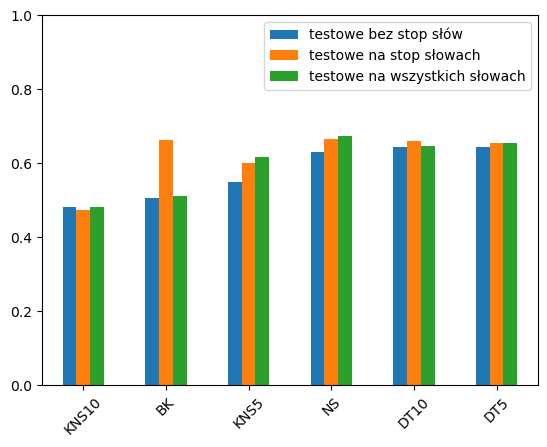

In [41]:
to_plot = pd.concat([respd1.drop(columns=['uczące']),
                        respd2.drop(columns=['uczące']),
                        respd3.drop(columns=['uczące'])], axis=1)
to_plot.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot.plot(kind='bar', rot = 45, ylim=[0,1])

Na podstawie tych klasyfikacji widzimy, że jesteśmy w stanie otrzymać dość dobre wyniki dla klasyfikatorów, które mają rząd wielkości około 70%. 

___

Następną klasyfikacje wykonamy przy pomocy metryki tfidf.

Klasyfickaja bez stop słów z metryką TFIDF


<AxesSubplot:>

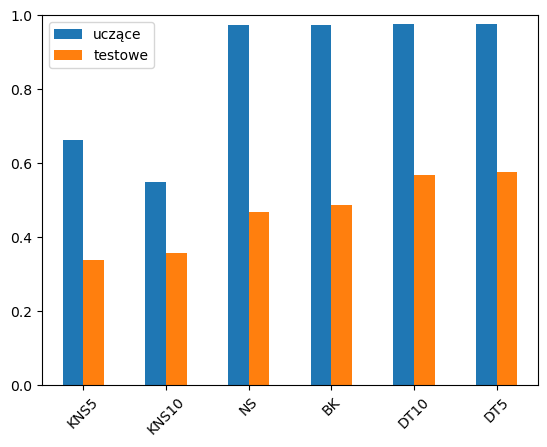

In [43]:
print("Klasyfickaja bez stop słów z metryką TFIDF")
respdTF1 = test_classifiers(data1, tfidf_arg=True, tries=liczba_prób)
respdTF1.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na stop słowach z metryką TFIDF


<AxesSubplot:>

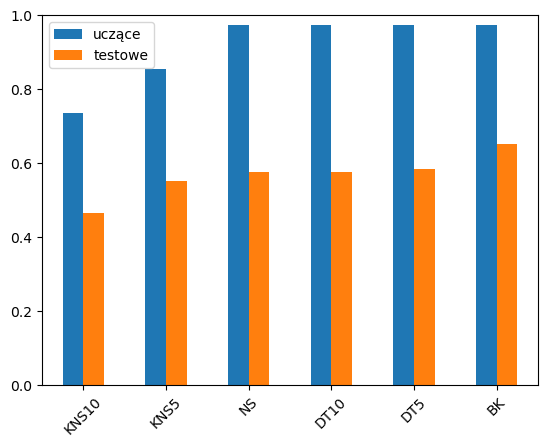

In [44]:
print("Klasyfickaja na stop słowach z metryką TFIDF")
respdTF2 = test_classifiers(data2, tfidf_arg=True, tries=liczba_prób)
respdTF2.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na wszyskich słowach z metryką TFIDF


<AxesSubplot:>

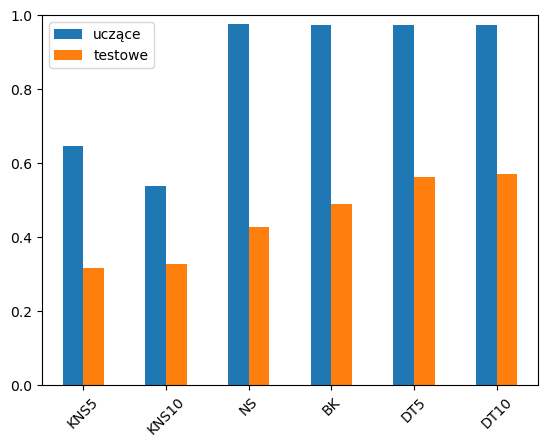

In [45]:
print("Klasyfickaja na wszyskich słowach z metryką TFIDF")
respdTF3 = test_classifiers(data3, tfidf_arg=True, tries=liczba_prób)
respdTF3.plot(kind='bar', rot = 45,  ylim=[0,1])

<AxesSubplot:>

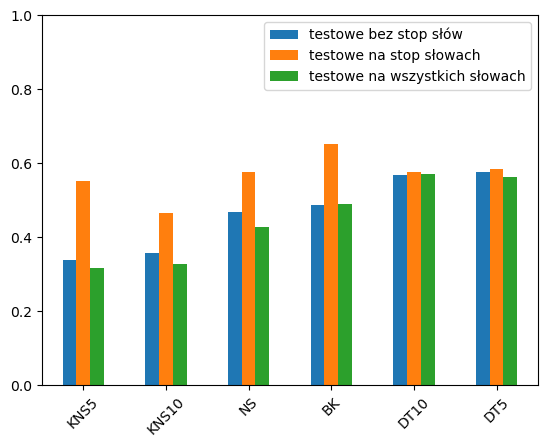

In [46]:
to_plot_TF = pd.concat([respdTF1.drop(columns=['uczące']),
                        respdTF2.drop(columns=['uczące']),
                        respdTF3.drop(columns=['uczące'])], axis=1)
to_plot_TF.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot_TF.plot(kind='bar', rot = 45, ylim=[0,1])

Przy użyciu metryki TFIDF udało nam się trochę "ulepszyć" zbiór uczący. Jak widzimy teraz wyniki uzyskiwane przez poszczególne klasyfikatory są trochę lepsze

Klasyfikacja gdy łączymy wszystkie dzieła 1 autora.

In [47]:
print("Klasyfickaja na stop słowach")
respdNS1 = test_classifiers(data1, NS=True, tries=liczba_prób)
print("Klasyfickaja bez stop słów")
respdNS2 = test_classifiers(data2, NS=True, tries=liczba_prób)
print("Klasyfickaja na wszystkich słowach")
respdNS3 = test_classifiers(data3, NS=True, tries=liczba_prób)
print("##################################")

Klasyfickaja na stop słowach
Klasyfickaja bez stop słów
Klasyfickaja na wszystkich słowach
##################################


<AxesSubplot:>

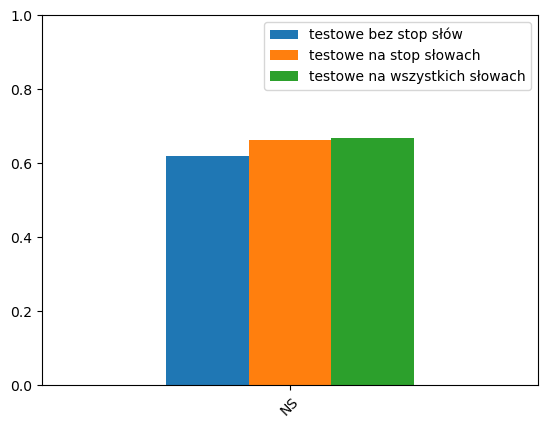

In [48]:
to_plot_NS = pd.concat([respdNS1.drop(columns=['uczące']),
                        respdNS2.drop(columns=['uczące']),
                        respdNS3.drop(columns=['uczące'])], axis=1)
to_plot_NS.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot_NS.plot(kind='bar', rot = 45,  ylim=[0,1])

Przy użwyaniu prototypu autora uzyskujemy podobne do siebie wyniki nie zależnie od przyjętej metody. Choć minimalnie lepszy okazały się być worki słów na wszystkich słowach, jednakże (żaden ze mnie Sienkiewicz) różnica między danymi na stop słowach są znikome a oszczędność obliczeniowa jest duża, co może być ważną cechą do odnotowania.

           testowe
f3DT10  0.67362500
NSn3    0.66800000
f2DT10  0.66625000
NSn2    0.66237500
f2DT5   0.66187500
f2BK    0.66000000
f2KNS10 0.65537500
f3DT5   0.65500000
t2DT10  0.65262500
f1DT10  0.65037500
f3BK    0.64625000
f1DT5   0.63550000
f1BK    0.62425000
NSn1    0.61837500
f3KNS10 0.61537500
f2KNS5  0.59937500
t2DT5   0.58387500
t2BK    0.57637500
t2KNS10 0.57562500
t1DT10  0.57487500
t3DT10  0.56937500
t1DT5   0.56862500
t3DT5   0.56300000
t2KNS5  0.55225000
f1KNS10 0.55075000
f3KNS5  0.51187500
f1KNS5  0.50550000
t3BK    0.48812500
t1BK    0.48762500
f3NS    0.48125000
f2NS    0.47212500
t1KNS10 0.46787500
f1NS    0.46475000
t2NS    0.46462500
t3KNS10 0.42587500
t1KNS5  0.35587500
t1NS    0.33900000
t3KNS5  0.32687500
t3NS    0.31650000


<AxesSubplot:>

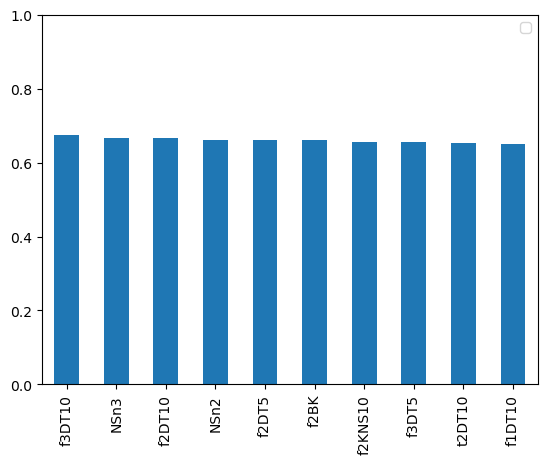

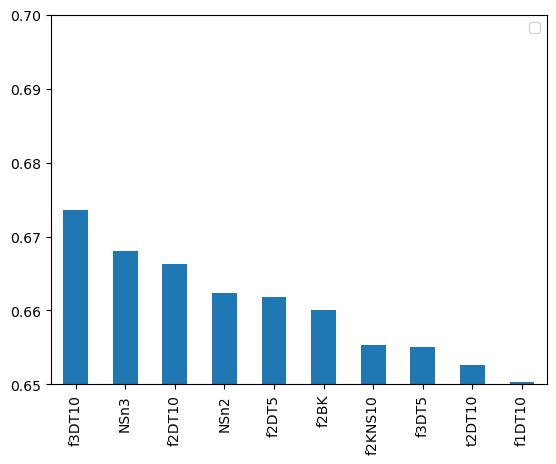

In [121]:
met1 = ('f1','f2','f3','t1','t2','t3')
met2 = ('NSn1','NSn2','NSn3')
kla = [name for name, _ in models]
lab = [m + k for m in met1 for k in kla]
lab += met2
l = (respd1.drop(columns=['uczące']),
     respd2.drop(columns=['uczące']),
     respd3.drop(columns=['uczące']),
     respdTF1.drop(columns=['uczące']),
     respdTF2.drop(columns=['uczące']),
     respdTF3.drop(columns=['uczące']),
     respdNS1.drop(columns=['uczące']),
     respdNS2.drop(columns=['uczące']),
     respdNS3.drop(columns=['uczące']))
df = pd.concat(l)
df.index = lab
df = df.sort_values(by='testowe', ascending=False)
print(df)
tmp = df.head(10)
tmp = tmp

tmp.columns= ['_']
tmp.plot(kind='bar', rot = 90, ylim=[0,1], width=0.5)
tmp.plot(kind='bar', rot = 90, ylim=[0.65,0.7], width=0.5)

In [79]:
def test_for_lengths(model, traindf, files, mini=100, maxi=5100, step=1000, tries=10):
    classificator = model
    classificator.fit(traindf.drop(columns='labels'), traindf['labels'])
    books = []
    labels = []
    index = []
    results = []
    sizes = []
    nmin = np.Infinity
    
    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        labels.append(label)
        index.append(name)
        n, cont = get_text(path)
        cont = normalize_text(cont)
        cont = cont.replace('\n', ' ')
        words = cont.split(' ')
        nmin = min(nmin, len(words))
        books.append(words)
        
    line = "Ukończono w {pr:.2f}%"
    s = (maxi - mini)//step
    progress = s*tries
    
    for i in range(mini, maxi + 1, step):
        sum = 0
        if i >= nmin:
            break
        for t in range(tries):
            print(line.format(pr=(((i - mini)//step*tries + t + 1)*100/progress)), end='\r')         
            bags = []
            
            for text in books:
                start = random.randint(0, len(text) - i)
                bags.append(bag_from_list(text[start:], mode=0, nwords=i))
                
            df = merge_dics_to_df(bags)
            df = frequency(df)
            df['labels'] = labels
            df = df.merge(traindf, how='left')
            df = df[traindf.columns]
            df = df.fillna(0)
            
            sum += classificator.score(df.drop(columns='labels'), df['labels'])
        results.append(sum / tries)
        sizes.append(i)
    return results, sizes

In [61]:
def test_for_lengths(model, traindf, files, mini=100, maxi=5100, step=1000, tries=10):
    classificator = model
    classificator.fit(traindf.drop(columns='labels'), traindf['labels'])
    books = []
    labels = []
    index = []
    results = []
    sizes = []
    nmin = np.Infinity
    
    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        labels.append(label)
        index.append(name)
        n, cont = get_text(path)
        cont = normalize_text(cont)
        cont = cont.replace('\n', ' ')
        words = cont.split(' ')
        nmin = min(nmin, len(words))
        books.append(words)
        
    line = "Ukończono w {pr:.2f}%"
    s = (maxi - mini)//step
    progress = s*tries
    
    gen = range(mini, maxi + 1, step)
    sizes = [*gen]
    
    sum = [0] * len(sizes)

    for t in range(tries):
        print(line.format(pr=((t + 1)*100/tries)), end='\r')         
        bags = []

        for text in books:
            start = random.randint(0, len(text))
            bags.append(bag_from_list(text[start:], mode=0, nwords=gen))

        for batch in zip(bags):
            df = merge_dics_to_df(batch)
            df = frequency(df)
            df['labels'] = labels
            df = df.merge(traindf, how='left')
            df = df[traindf.columns]
            df = df.fillna(0)

        sum += classificator.score(df.drop(columns='labels'), df['labels'])
    results.append(sum / tries)
        
    return results, sizes

In [80]:
def bag_from_list(lst, mode=0, nwords=0):
    word_bag = {}
    words_in_bag = 0
    for word in lst:
        if words_in_bag >= nwords:
            break
        if word == '':
            continue
        if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
            words_in_bag += 1
            if word in word_bag:
                word_bag[word] += 1
            else:
                word_bag[word] = 1
    return word_bag     

In [87]:
data = load(files.drop([0, 11, 23]), mode=0)
fdata = frequency(data)

In [88]:
r, s = test_for_lengths(tree.DecisionTreeClassifier(max_depth=5), fdata, files.loc[[0, 11, 23],:], mini=100, maxi=2000, step=100, tries=10)
print('rozmiary: ', s)
print(r)

KeyboardInterrupt: 

In [ ]:
so = io.StringIO()
sortby = SortKey.CUM
ps = pstats.Stats(pr, stream=so).sort_stats(sortby)
ps.print_stats()
print(so.getvalue())

Text(0.5, 0, 'number of words')

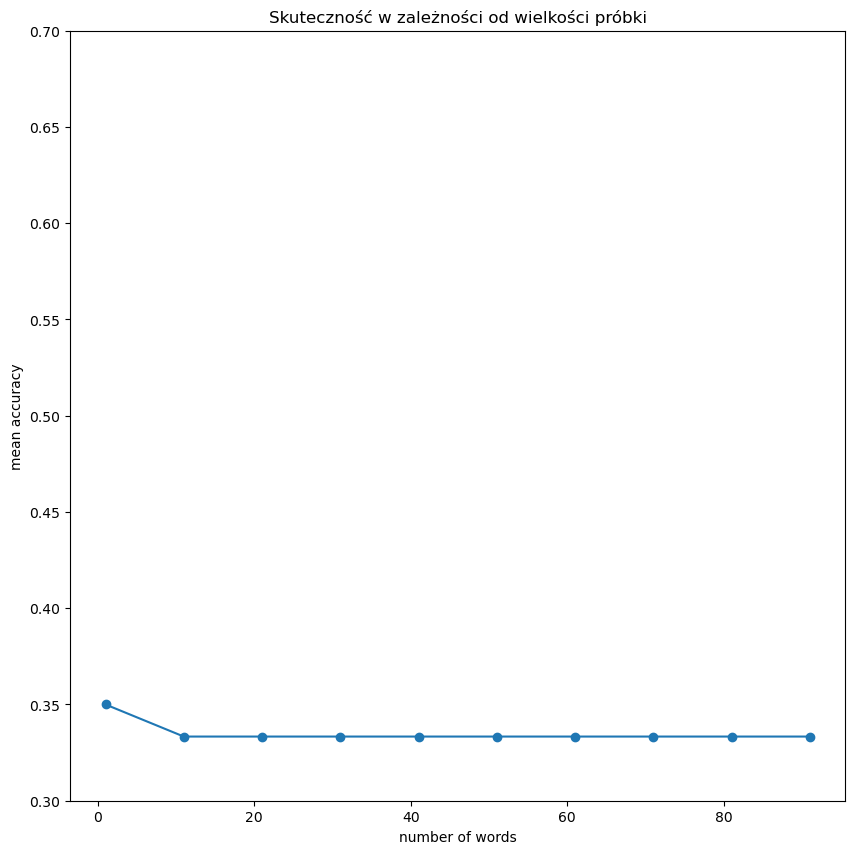

In [40]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(s, r, marker='o')
plt.title('Skuteczność w zależności od wielkości próbki')
plt.ylim([0.3, 0.7])
plt.ylabel('mean accuracy')
plt.xlabel('number of words')